## Подготовка данных

Импортируем необходимые библиотеки и модули для работы

In [1]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier, Pool, cv
from sklearn.dummy import DummyClassifier
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, f1_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Загрузим данные и сделаем небольшой обзор данных, при необходимости их подготовим для дальнейшего исследования

In [3]:
df = pd.read_csv('/content/Churn.csv')

In [4]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Описание данных:
* `RowNumber` — индекс строки в данных
* `CustomerId` — уникальный идентификатор клиента
* `Surname` — фамилия
* `CreditScore` — кредитный рейтинг
* `Geography` — страна проживания
* `Gender` — пол
* `Age` — возраст
* `Tenure` — сколько лет человек является клиентом банка
* `Balance` — баланс на счёте
* `NumOfProducts` — количество продуктов банка, используемых клиентом
* `HasCrCard` — наличие кредитной карты
* `IsActiveMember` — активность клиента
* `EstimatedSalary` — предполагаемая зарплата
* `Exited` — факт ухода клиента

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Переименуем названия столбцов для удобства, а так же избавимся от части столбцов **RowNumber**, **Surname**, **CustomerID**, которые для нашего исследования не несут смысловой нагрузки.

In [6]:
df1 = df.drop(['RowNumber','Surname', 'CustomerId'],axis=1)

In [7]:
df1.columns = ['credit_score', 'geography', 'gender', 'age', 'tenure',
       'balance', 'num_of_products', 'has_cr_card', 'is_active_member',
       'estimated_salary', 'exited']

Видно, что в столбце `tenure` есть пропуски, необходимо их заполнить, потому что удалить данные нельзя из-за их количества (около 10% от общего кол-ва данных)

In [8]:
df1['tenure'].value_counts(normalize=True, dropna=False)

1.0     0.0952
2.0     0.0950
8.0     0.0933
3.0     0.0928
5.0     0.0927
7.0     0.0925
NaN     0.0909
4.0     0.0885
9.0     0.0882
6.0     0.0881
10.0    0.0446
0.0     0.0382
Name: tenure, dtype: float64

Из распределения данной величины видно, что данные распределены равномерно за исключением значений **0** и **10**. Поэтому предлагается заполнить половину пропусков значением **0**, другую половину значением **10**

In [9]:
df1 = df1.fillna(0, limit=df1['tenure'].isna().sum()//2) #Только половину пропусков заполняем 0

In [10]:
df1 = df1.fillna(10)

Проверяем

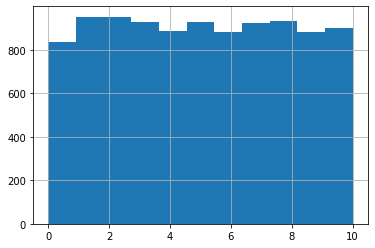

In [11]:
df1['tenure'].hist(bins=11)

In [12]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   geography         10000 non-null  object 
 2   gender            10000 non-null  object 
 3   age               10000 non-null  int64  
 4   tenure            10000 non-null  float64
 5   balance           10000 non-null  float64
 6   num_of_products   10000 non-null  int64  
 7   has_cr_card       10000 non-null  int64  
 8   is_active_member  10000 non-null  int64  
 9   estimated_salary  10000 non-null  float64
 10  exited            10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


Проверим на дубликаты

In [13]:
df1.duplicated().sum()

0

### Вывод
Сделали обзор данных и подготовили их к дальнейшему исследованию

## Исследование задачи

### Последние приготовления

Проверим как распределен целевой признак, который мы будем предсказывать с помощью машинного обучения

In [14]:
df1['exited'].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: exited, dtype: float64

На лицо дисбаланс классов. Согласно условиям исследования сделаем предсказания, не обращая на это внимание. Но сначала до конца подготовим данные для анализа. 

Для этого:
* преобразуем категориальные признаки, 
* разделим выборку на 3 части: тренировочную(60%), валидационную(20%) и тестовую(20%),
* масштабируем количественные признаки.

Преобразуем категориальные признаки

In [15]:
cat_data = ['geography','gender', 'num_of_products', 'has_cr_card', 'is_active_member']
num_data = ['credit_score','age','estimated_salary','balance','tenure']

In [16]:
df1 = pd.get_dummies(data=df1,columns=cat_data, drop_first=True)

Разобьем выборку на три части: тренировочную (60%), валидационную (20%) и тестовую (20%)

In [17]:
df_train, df_temp = train_test_split(df1, test_size=0.4, random_state=101)
df_valid, df_test = train_test_split(df_temp, test_size=0.5, random_state=101)

Проверка

In [18]:
display(df_train.shape)
display(df_valid.shape)
display(df_test.shape)

(6000, 14)

(2000, 14)

(2000, 14)

Данные для обучения

In [19]:
features_train = df_train.drop(['exited'], axis=1)
target_train = df_train['exited']

Данные для валидации

In [20]:
features_valid = df_valid.drop(['exited'], axis=1)
target_valid = df_valid['exited']

Данные для тестирования

In [21]:
features_test = df_test.drop(['exited'], axis=1)
target_test = df_test['exited']

Масштабируем количественные признаки

In [22]:
scaler = StandardScaler()
scaler.fit(features_train[num_data]) 
features_train[num_data] = scaler.transform(features_train[num_data])
features_valid[num_data] = scaler.transform(features_valid[num_data])
features_test[num_data] = scaler.transform(features_test[num_data])

Рассмотрим, как справится с не балансированными классами разные алгоритмы машинного обучения - **RandomForest, SVM, CatBoost**

### RandomForest

Для подбора гиперпараметров воспользуемся **GridSearchCV**

In [23]:
#Время выполнения ячеки около пары минут
tuned_parameters = {"n_estimators": list(range(60,121,20)), 
                    "max_depth": list(range(5,13,1)), 
                    "criterion": ['gini', 'entropy']}

rand_forest = GridSearchCV(RandomForestClassifier(random_state=101), 
                   tuned_parameters, scoring='f1', cv=5)
rand_forest.fit(features_train, target_train)
print("Best parameters set found on development set:")
print(rand_forest.best_params_)
print()
print("Grid scores on development set:")
means = rand_forest.cv_results_["mean_test_score"]
stds = rand_forest.cv_results_["std_test_score"]
for mean, std, params in zip(means, stds, rand_forest.cv_results_["params"]):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print()

print("Detailed classification report:")
target_pred = rand_forest.predict(features_valid)
print(classification_report(target_valid, target_pred))

Best parameters set found on development set:
{'criterion': 'gini', 'max_depth': 12, 'n_estimators': 60}

Grid scores on development set:
0.454 (+/-0.028) for {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 60}
0.446 (+/-0.022) for {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 80}
0.444 (+/-0.031) for {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 100}
0.447 (+/-0.035) for {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 120}
0.502 (+/-0.032) for {'criterion': 'gini', 'max_depth': 6, 'n_estimators': 60}
0.498 (+/-0.017) for {'criterion': 'gini', 'max_depth': 6, 'n_estimators': 80}
0.500 (+/-0.024) for {'criterion': 'gini', 'max_depth': 6, 'n_estimators': 100}
0.505 (+/-0.025) for {'criterion': 'gini', 'max_depth': 6, 'n_estimators': 120}
0.544 (+/-0.020) for {'criterion': 'gini', 'max_depth': 7, 'n_estimators': 60}
0.539 (+/-0.027) for {'criterion': 'gini', 'max_depth': 7, 'n_estimators': 80}
0.537 (+/-0.023) for {'criterion': 'gini', 'max_depth': 7, 'n_estima

Как видно из итоговой таблицы метрик, полнота меньше 0,5 для класса "1". То есть модель слабо предсказывает данный класс. Что в свою очередь уменьшает значение итоговой метрики **F-1**. Посмотрим далее, как она изменится для случая с сбалансированными классами.

Создадим итоговую таблицу с ключевыми метриками и будем ее наполнять по ходу исследования

In [24]:
#заново создаем отчет, чтобы иметь вывод в словарь, для простого доступа к содержимому
rand_forest_report = classification_report(target_valid, target_pred, output_dict=True)

In [25]:
result_df = pd.DataFrame(columns=['name_ml', 'f1_valid_NB', 'f1_valid_B', 'f1_test_B'])

In [26]:
result_df.loc[0]=['RandomForest', round(rand_forest_report['1']['f1-score'], 2), 0, 0]

In [27]:
result_df

,name_ml,f1_valid_NB,f1_valid_B,f1_test_B
0,RandomForest,0.6,0,0


### SVM

Аналогично для подбора лучших параметров воспользуемся **GridSearchCV**

In [28]:
#Время выполнения ячеки около 7-10 минут
tuned_parameters = {"C": np.logspace(-3, 3, num=7), 
                    "gamma": np.logspace(-5, 2, num=8)}

svm = GridSearchCV(SVC(kernel='rbf', random_state=101), 
                    tuned_parameters, cv=5)
svm.fit(features_train, target_train)
print("Best parameters set found on development set:")
print(svm.best_params_)
print()
print("Grid scores on development set:")
means = svm.cv_results_["mean_test_score"]
stds = svm.cv_results_["std_test_score"]
for mean, std, params in zip(means, stds, svm.cv_results_["params"]):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print()

print("Detailed classification report:")
target_pred = svm.predict(features_valid)
print(classification_report(target_valid, target_pred))

Best parameters set found on development set:
{'C': 10.0, 'gamma': 0.1}

Grid scores on development set:
0.796 (+/-0.001) for {'C': 0.001, 'gamma': 1e-05}
0.796 (+/-0.001) for {'C': 0.001, 'gamma': 0.0001}
0.796 (+/-0.001) for {'C': 0.001, 'gamma': 0.001}
0.796 (+/-0.001) for {'C': 0.001, 'gamma': 0.01}
0.796 (+/-0.001) for {'C': 0.001, 'gamma': 0.1}
0.796 (+/-0.001) for {'C': 0.001, 'gamma': 1.0}
0.796 (+/-0.001) for {'C': 0.001, 'gamma': 10.0}
0.796 (+/-0.001) for {'C': 0.001, 'gamma': 100.0}
0.796 (+/-0.001) for {'C': 0.01, 'gamma': 1e-05}
0.796 (+/-0.001) for {'C': 0.01, 'gamma': 0.0001}
0.796 (+/-0.001) for {'C': 0.01, 'gamma': 0.001}
0.796 (+/-0.001) for {'C': 0.01, 'gamma': 0.01}
0.796 (+/-0.001) for {'C': 0.01, 'gamma': 0.1}
0.796 (+/-0.001) for {'C': 0.01, 'gamma': 1.0}
0.796 (+/-0.001) for {'C': 0.01, 'gamma': 10.0}
0.796 (+/-0.001) for {'C': 0.01, 'gamma': 100.0}
0.796 (+/-0.001) for {'C': 0.1, 'gamma': 1e-05}
0.796 (+/-0.001) for {'C': 0.1, 'gamma': 0.0001}
0.796 (+/-0.001)

Как видно из итоговой таблицы метрик, полнота меньше 0,5 для класса "1". То есть модель слабо предсказывает данный класс. Что в свою очередь уменьшает значение итоговой метрики **F-1**. Посмотрим далее, как она изменится для случая с сбалансированными классами. Однако значение метрики уже удовлетворяет условию исследования. Результат занесем в итоговую таблицу

In [29]:
#заново создаем отчет, чтобы иметь вывод в словарь, для простого доступа к содержимому
svm_report = classification_report(target_valid, target_pred, output_dict=True)

In [30]:
result_df.loc[1]=['SVM', round(svm_report['1']['f1-score'], 2), 0, 0]

In [31]:
result_df

,name_ml,f1_valid_NB,f1_valid_B,f1_test_B
0,RandomForest,0.60,0,0
1,SVM,0.59,0,0


### CatBoost

Рассмотрим последний алгоритм

In [32]:
cat_data = ['geography_Germany', 'geography_Spain', 'gender_Male',
       'num_of_products_2', 'num_of_products_3', 'num_of_products_4',
       'has_cr_card_1', 'is_active_member_1']

In [33]:
model_cat = CatBoostClassifier(random_seed=101,
                               learning_rate=0.15,
                               loss_function = 'Logloss',
                               silent=True, 
                               early_stopping_rounds=20)

model_cat.fit(features_train, target_train, eval_set=(features_valid, target_valid))

params = model_cat.get_params()

cv_data = cv(
    params=params,
    pool=Pool(features_train, target_train, cat_features=cat_data),
    fold_count=5, # Разбивка выборки на 5 кусочков
    shuffle=True, # Перемешаем данные
    partition_random_seed=0,
    stratified=True
)

print("Detailed classification report:")
target_pred = model_cat.predict(features_valid)
print(classification_report(target_valid, target_pred))

Training on fold [0/5]

bestTest = 0.3344414054
bestIteration = 54

Training on fold [1/5]

bestTest = 0.3387912433
bestIteration = 27

Training on fold [2/5]

bestTest = 0.343788843
bestIteration = 35

Training on fold [3/5]

bestTest = 0.3306530227
bestIteration = 47

Training on fold [4/5]

bestTest = 0.3651961864
bestIteration = 35

Detailed classification report:
              precision    recall  f1-score   support

           0       0.89      0.96      0.92      1596
           1       0.77      0.51      0.61       404

    accuracy                           0.87      2000
   macro avg       0.83      0.73      0.77      2000
weighted avg       0.86      0.87      0.86      2000



In [34]:
#заново создаем отчет, чтобы иметь вывод в словарь, для простого доступа к содержимому
cat_report = classification_report(target_valid, target_pred, output_dict=True)

In [35]:
result_df.loc[2]=['CatBoost', round(cat_report['1']['f1-score'], 2), 0, 0]

In [36]:
result_df

,name_ml,f1_valid_NB,f1_valid_B,f1_test_B
0,RandomForest,0.60,0,0
1,SVM,0.59,0,0
2,CatBoost,0.61,0,0


### Вывод

Проверили, как модели предсказывают значение с небалансированными классами, результаты занесли в таблицу. Лучшим, пока является **CatBoost**. В следующем пункте сделаем баланс классов, и посмотрим, как изменится значение **F-1 меры**

## Борьба с дисбалансом

Отбалансируем классы и сравним с прошлыми значения **F-1**. В ручную сбалансируем классы, путем **upsampling** и **downsampling**, количество отрицательных ответов уменьшим в 2 раза и количество положительных увеличим в 2 раза. Тем самым приведем количество 0 и 1 к примерно равному количеству.

In [37]:
target_train.value_counts()

0    4776
1    1224
Name: exited, dtype: int64

In [38]:
def updownsample(features, target, up_rate, down_rate):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_updownsampled = pd.concat([features_zeros.sample(frac=1/down_rate, 
                                        random_state=101)] + [features_ones] * up_rate)
    target_updownsampled = pd.concat([target_zeros.sample(frac=1/down_rate, random_state=101)] 
                             + [target_ones] * up_rate)
    
    features_updownsampled, target_updownsampled = shuffle(features_updownsampled, 
                                                    target_updownsampled, random_state=101)
       
    return features_updownsampled, target_updownsampled

In [39]:
features_mixed, target_mixed = updownsample(features_train, target_train, 2, 2)

Проверка

In [40]:
target_mixed.value_counts()

1    2448
0    2388
Name: exited, dtype: int64

Теперь осталось проверить, как повлияла наша ручная балансировка на изменение метрики **F-1**

### RandomForest

In [41]:
rand_forest.best_estimator_.fit(features_mixed, target_mixed)
print("Detailed classification report:")
target_pred = rand_forest.predict(features_valid)
print(classification_report(target_valid, target_pred))

Detailed classification report:
              precision    recall  f1-score   support

           0       0.92      0.83      0.88      1596
           1       0.52      0.72      0.61       404

    accuracy                           0.81      2000
   macro avg       0.72      0.78      0.74      2000
weighted avg       0.84      0.81      0.82      2000



In [42]:
#заново создаем отчет, чтобы иметь вывод в словарь, для простого доступа к содержимому
rand_forest_report = classification_report(target_valid, target_pred, output_dict=True)

In [43]:
result_df.loc[0, 'f1_valid_B'] = round(rand_forest_report['1']['f1-score'],2)

In [44]:
result_df

,name_ml,f1_valid_NB,f1_valid_B,f1_test_B
0,RandomForest,0.60,0.61,0
1,SVM,0.59,0,0
2,CatBoost,0.61,0,0


После балансировки значение метрики улучшилось на 0,01.

### SVM

In [45]:
svm.best_estimator_.fit(features_mixed, target_mixed)
print("Detailed classification report:")
target_pred = svm.predict(features_valid)
print(classification_report(target_valid, target_pred))

Detailed classification report:
              precision    recall  f1-score   support

           0       0.93      0.78      0.85      1596
           1       0.46      0.77      0.58       404

    accuracy                           0.77      2000
   macro avg       0.70      0.77      0.71      2000
weighted avg       0.84      0.77      0.79      2000



In [46]:
#заново создаем отчет, чтобы иметь вывод в словарь, для простого доступа к содержимому
svm_report = classification_report(target_valid, target_pred, output_dict=True)

In [47]:
result_df.loc[1, 'f1_valid_B'] = round(svm_report['1']['f1-score'],2)

In [48]:
result_df

,name_ml,f1_valid_NB,f1_valid_B,f1_test_B
0,RandomForest,0.60,0.61,0
1,SVM,0.59,0.58,0
2,CatBoost,0.61,0,0


После балансировки значение метрики ухудшилось на 0,01.

### Catboost

In [49]:
model_cat.fit(features_mixed, target_mixed, eval_set=(features_valid, target_valid))
print("Detailed classification report:")
target_pred = model_cat.predict(features_valid)
print(classification_report(target_valid, target_pred))

Detailed classification report:
              precision    recall  f1-score   support

           0       0.93      0.81      0.86      1596
           1       0.50      0.77      0.61       404

    accuracy                           0.80      2000
   macro avg       0.72      0.79      0.74      2000
weighted avg       0.85      0.80      0.81      2000



In [50]:
#заново создаем отчет, чтобы иметь вывод в словарь, для простого доступа к содержимому
cat_report = classification_report(target_valid, target_pred, output_dict=True)

In [51]:
result_df.loc[2, 'f1_valid_B'] = round(cat_report['1']['f1-score'],2)

In [52]:
result_df

,name_ml,f1_valid_NB,f1_valid_B,f1_test_B
0,RandomForest,0.60,0.61,0
1,SVM,0.59,0.58,0
2,CatBoost,0.61,0.61,0


После балансировки значение метрики не изменилось.

### Вывод

Отбалансировали классы путем изменения количественного состава. Обучили модели на новых сбалансированных данных. Значения метрики **F-1** улучшилось только для Случайного Леса, для остальных алгоритмов результаты балансировки привели к ухудшению или неизменности меры **F-1**. Проверим, как ведут себя наши модели на тестовой выборке.

## Тестирование модели

### RandomForest

Проверим как наша модель справится с тестовой выборкой.

In [53]:
print("Detailed classification report:")
target_pred = rand_forest.predict(features_test)
print(classification_report(target_test, target_pred))

Detailed classification report:
              precision    recall  f1-score   support

           0       0.92      0.84      0.88      1591
           1       0.54      0.73      0.62       409

    accuracy                           0.82      2000
   macro avg       0.73      0.79      0.75      2000
weighted avg       0.85      0.82      0.83      2000



Отличный результат, модель на не знакомых данных улучшила свою метрику.

In [54]:
#заново создаем отчет, чтобы иметь вывод в словарь, для простого доступа к содержимому
rand_forest_report = classification_report(target_test, target_pred, output_dict=True)

In [55]:
result_df.loc[0, 'f1_test_B'] = round(rand_forest_report['1']['f1-score'],2)

In [56]:
result_df

,name_ml,f1_valid_NB,f1_valid_B,f1_test_B
0,RandomForest,0.60,0.61,0.62
1,SVM,0.59,0.58,0
2,CatBoost,0.61,0.61,0


Дополнительно построим и посчитаем **AUC-ROC**

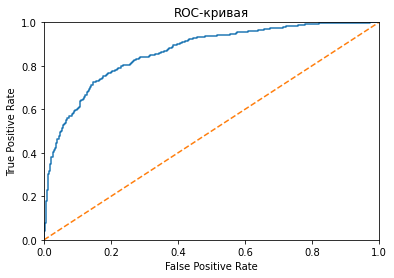


Площадь под ROC-кривой, AUC-ROC = 0.864382321708756


In [57]:
probabilities_test = rand_forest.best_estimator_.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.show()

print()
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('Площадь под ROC-кривой, AUC-ROC =', auc_roc)

### SVM

Перейдем к следующему алгоритму

In [58]:
print("Detailed classification report:")
target_pred = svm.predict(features_test)
print(classification_report(target_test, target_pred))

Detailed classification report:
              precision    recall  f1-score   support

           0       0.92      0.78      0.84      1591
           1       0.46      0.73      0.57       409

    accuracy                           0.77      2000
   macro avg       0.69      0.76      0.71      2000
weighted avg       0.83      0.77      0.79      2000



Значение метрики ухудшилось и, к сожалению, оно меньше требуемого значения.

In [59]:
#заново создаем отчет, чтобы иметь вывод в словарь, для простого доступа к содержимому
svm_report = classification_report(target_test, target_pred, output_dict=True)

In [60]:
result_df.loc[1, 'f1_test_B'] = round(svm_report['1']['f1-score'],2)

In [61]:
result_df

,name_ml,f1_valid_NB,f1_valid_B,f1_test_B
0,RandomForest,0.60,0.61,0.62
1,SVM,0.59,0.58,0.57
2,CatBoost,0.61,0.61,0


Дополнительно построим и посчитаем **AUC-ROC**

Включим опцию **probability** и заново обучим модель, так как по умолчанию она выключена

In [62]:
svm = SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=True, random_state=101, shrinking=True, tol=0.001,
    verbose=False)

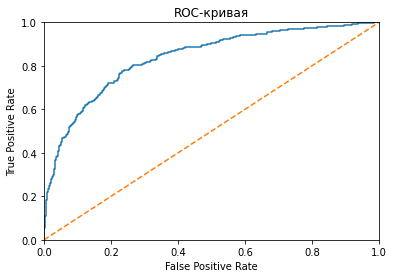


Площадь под ROC-кривой, AUC-ROC = 0.8378301540296196


In [63]:
svm.fit(features_mixed, target_mixed)
probabilities_test = svm.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.show()

print()
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('Площадь под ROC-кривой, AUC-ROC =', auc_roc)

### CatBoost

Проверим последний алгоритм на тестовой выборке

In [64]:
print("Detailed classification report:")
target_pred = model_cat.predict(features_test)
print(classification_report(target_test, target_pred))

Detailed classification report:
              precision    recall  f1-score   support

           0       0.92      0.81      0.86      1591
           1       0.50      0.74      0.60       409

    accuracy                           0.80      2000
   macro avg       0.71      0.77      0.73      2000
weighted avg       0.84      0.80      0.81      2000



In [65]:
#заново создаем отчет, чтобы иметь вывод в словарь, для простого доступа к содержимому
cat_report = classification_report(target_test, target_pred, output_dict=True)

In [66]:
result_df.loc[2, 'f1_test_B'] = round(cat_report['1']['f1-score'],2)

In [67]:
result_df

,name_ml,f1_valid_NB,f1_valid_B,f1_test_B
0,RandomForest,0.60,0.61,0.62
1,SVM,0.59,0.58,0.57
2,CatBoost,0.61,0.61,0.6


Дополнительно построим и посчитаем **AUC-ROC**

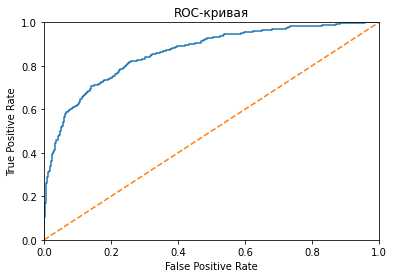


Площадь под ROC-кривой, AUC-ROC = 0.8613595115556791


In [68]:
probabilities_test = model_cat.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.show()

print()
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('Площадь под ROC-кривой, AUC-ROC =', auc_roc)

### Тест на адекватность

Дополнительно проверим наши модели на адекватность

Сначала проверим для случая равных классов

In [69]:
dummy1 = DummyClassifier(strategy='uniform', random_state=101).fit(features_mixed, target_mixed)
print("Detailed classification report:")
target_pred = dummy1.predict(features_test)
print(classification_report(target_test, target_pred))

Detailed classification report:
              precision    recall  f1-score   support

           0       0.79      0.49      0.61      1591
           1       0.20      0.50      0.29       409

    accuracy                           0.49      2000
   macro avg       0.50      0.50      0.45      2000
weighted avg       0.67      0.49      0.54      2000



Отлично, наши модели намного лучше случайной модели с равными классами

А теперь проверим для случая доминирования одного из классов. В этом случае обучать модель будем на исходных данных, а не сбалансированных mixed таблицах.

In [70]:
dummy2 = DummyClassifier(strategy='constant', constant=[1],
                         random_state=101).fit(features_train, target_train)
print("Detailed classification report:")
target_pred = dummy2.predict(features_test)
print(classification_report(target_test, target_pred))

Detailed classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1591
           1       0.20      1.00      0.34       409

    accuracy                           0.20      2000
   macro avg       0.10      0.50      0.17      2000
weighted avg       0.04      0.20      0.07      2000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Так как мы указали **1** для предсказаний, то **0** не заполнялся и выдается *Warning*

## Вывод

На основе исторических данных предоставленных банком, обучили модели для предсказывания оттока клиентов лучше всех с данной задачей справился алгоритм **RandomForest** c результатом **F-1 = 0.62**, на удивление запасной моделью является **CatBoost** на несбалансированных данных показал результат **F-1 = 0.61**. Что и требовалось получить в данной работе.

In [71]:
result_df

,name_ml,f1_valid_NB,f1_valid_B,f1_test_B
0,RandomForest,0.60,0.61,0.62
1,SVM,0.59,0.58,0.57
2,CatBoost,0.61,0.61,0.6


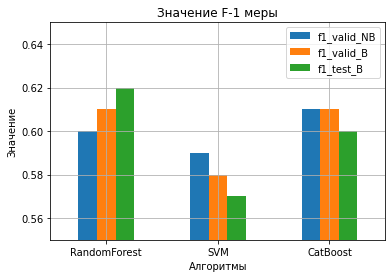

In [72]:
result_df.plot(kind='bar')
plt.title('Значение F-1 меры')
plt.xlabel('Алгоритмы')
plt.ylabel('Значение')
plt.xticks(range(len(result_df['name_ml'])), labels=result_df['name_ml'], rotation=0)
plt.ylim(0.55,0.65)
plt.grid()
plt.show()